In [6]:
# from holidays.countries.united_states import US
# import holidays
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import isnan, when, count, col, lit, udf
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.context import SparkContext
import pandas as pd 
import numpy as np 
import re
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy import distance
import pickle
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import datetime
from dateutil.relativedelta import relativedelta
from functools import reduce
from pyspark.ml.feature import Bucketizer
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler
import ssl
from urllib import request
from PIL import Image

spark = SparkSession.builder.appName("tripDataCSVLoad").getOrCreate()

In [ ]:
# No holiday in April 2013

# #Holiday
# us_holidays = []
# for date in holidays.UnitedStates(years=2013).items():
#        us_holidays.append(date[0])

# print(us_holidays)

In [7]:
df_trip=spark.read.parquet("spark-warehouse/trip_clean_all")
print(df_trip.count())
print(df_trip.schema.names)

14623320
['medallion', 'hack_license', 'vendor_id', 'pickup_datetime', 'rate_code', 'store_and_fwd_flag', 'dropoff_datetime', 'passenger_count', 'trip_time_in_secs', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_area', 'dropoff_area', 'geo_distance', 'payment_type', 'fare_amount', 'surcharge', 'mta_tax', 'tip_amount', 'tolls_amount', 'total_amount', 'trip_id']


## Add fare_per_mile and sec_per_mile

In [9]:
### calculate fare_per_mile, sec_per_mile
df_trip = df_trip.withColumn('fare_per_mile',F.round(col('fare_amount')/col('geo_distance'),2))\
    .withColumn('sec_per_mile',F.round(col('trip_time_in_secs')/col('geo_distance'),1))

## Exploratory Data Analysis: Fare and Time

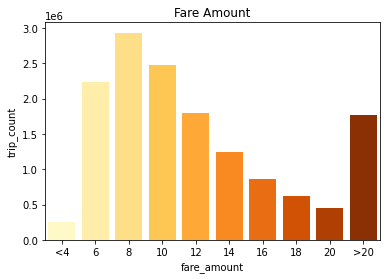

In [9]:
### fare_amount

percentile_list = [i/100.0 for i in range(0,110,10)]

quantiles = df_trip\
    .select(F.percentile_approx('fare_amount', percentile_list, 1000000).alias('quantiles')).collect()[0].quantiles

threshold = [2.5]+[i for i in range(4,22,2)] + [quantiles[-1]]

bucketizer = Bucketizer(splits=threshold,inputCol="fare_amount", outputCol="buckets")
df_buck = bucketizer.setHandleInvalid("skip").transform(df_trip)
# df_buck.select('fare_per_mile','buckets').show(5)

bucketlabels = [str('<')+str(threshold[1])]+[str(i) for i in threshold[2:-1]] + [str('>')+str(threshold[-2])]
bucketlabels_dict = dict(enumerate(bucketlabels))

df_fare_amount_grouped = df_buck.groupBy('buckets').count().toPandas().sort_values(by=['buckets'])
df_fare_amount_grouped['fare_amount'] = df_fare_amount_grouped['buckets'].apply(lambda x: bucketlabels_dict[x])
df_fare_amount_grouped = df_fare_amount_grouped.rename(columns={'count':'trip_count'})

ax = sns.barplot(x = 'fare_amount', y = 'trip_count', 
            data = df_fare_amount_grouped,
            palette = 'YlOrBr',
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'gray', errwidth = 2,  
            ci = 'sd'   
            )

ax.set_title('Fare Amount')
plt.show()

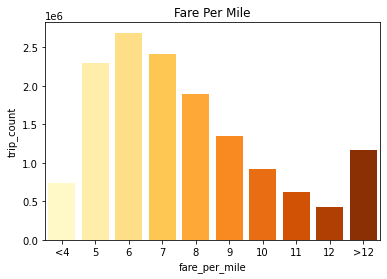

In [10]:
### fare_per_mile

percentile_list = [i/100.0 for i in range(0,110,10)]

quantiles = df_trip\
    .select(F.percentile_approx('fare_per_mile', percentile_list, 1000000).alias('quantiles')).collect()[0].quantiles

threshold = [0]+[i for i in range(4,13,1)] + [quantiles[-1]]

bucketizer = Bucketizer(splits=threshold,inputCol="fare_per_mile", outputCol="buckets")
df_buck = bucketizer.setHandleInvalid("skip").transform(df_trip)
# df_buck.select('fare_per_mile','buckets').show(5)

bucketlabels = [str('<')+str(threshold[1])]+[str(i) for i in threshold[2:-1]] + [str('>')+str(threshold[-2])]
bucketlabels_dict = dict(enumerate(bucketlabels))

df_fare_per_mile_grouped = df_buck.groupBy('buckets').count().toPandas().sort_values(by=['buckets'])
df_fare_per_mile_grouped['fare_per_mile'] = df_fare_per_mile_grouped['buckets'].apply(lambda x: bucketlabels_dict[x])
df_fare_per_mile_grouped = df_fare_per_mile_grouped.rename(columns={'count':'trip_count'})

ax = sns.barplot(x = 'fare_per_mile', y = 'trip_count', 
            data = df_fare_per_mile_grouped,
            palette = 'YlOrBr',
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'gray', errwidth = 2,  
            ci = 'sd'   
            )

ax.set_title('Fare Per Mile')
plt.show()

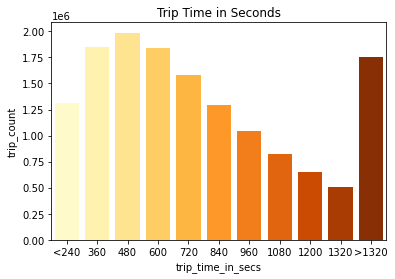

In [11]:
### trip_time_in_secs

percentile_list = [i/100.0 for i in range(0,110,10)]

quantiles = df_trip\
    .select(F.percentile_approx('trip_time_in_secs', percentile_list, 1000000).alias('quantiles')).collect()[0].quantiles

threshold = [0]+[i for i in range(240,1440,120)] + [quantiles[-1]]

bucketizer = Bucketizer(splits=threshold,inputCol="trip_time_in_secs", outputCol="buckets")
df_buck = bucketizer.setHandleInvalid("skip").transform(df_trip)
# df_buck.select('fare_per_mile','buckets').show(5)

bucketlabels = [str('<')+str(threshold[1])]+[str(i) for i in threshold[2:-1]] + [str('>')+str(threshold[-2])]
bucketlabels_dict = dict(enumerate(bucketlabels))

df_trip_time_grouped = df_buck.groupBy('buckets').count().toPandas().sort_values(by=['buckets'])
df_trip_time_grouped['trip_time_in_secs'] = df_trip_time_grouped['buckets'].apply(lambda x: bucketlabels_dict[x])
df_trip_time_grouped = df_trip_time_grouped.rename(columns={'count':'trip_count'})

ax = sns.barplot(x = 'trip_time_in_secs', y = 'trip_count', 
            data = df_trip_time_grouped,
            palette = 'YlOrBr',
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'gray', errwidth = 2,  
            ci = 'sd'   
            )

ax.set_title('Trip Time in Seconds')
plt.show()

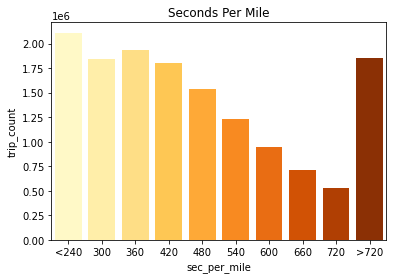

In [12]:
### sec_per_mile

percentile_list = [i/100.0 for i in range(0,110,10)]

quantiles = df_trip\
    .select(F.percentile_approx('sec_per_mile', percentile_list, 1000000).alias('quantiles')).collect()[0].quantiles

threshold = [0]+[i*60 for i in range(4,13,1)] + [quantiles[-1]]

bucketizer = Bucketizer(splits=threshold,inputCol="sec_per_mile", outputCol="buckets")
df_buck = bucketizer.setHandleInvalid("skip").transform(df_trip)
# df_buck.select('sec_per_mile','buckets').show(5)

bucketlabels = [str('<')+str(int(threshold[1]))]+[str(int(i)) for i in threshold[2:-1]] + [str('>')+str(int(threshold[-2]))]
bucketlabels_dict = dict(enumerate(bucketlabels))

df_sec_per_mile_grouped = df_buck.groupBy('buckets').count().toPandas().sort_values(by=['buckets'])
df_sec_per_mile_grouped['sec_per_mile'] = df_sec_per_mile_grouped['buckets'].apply(lambda x: bucketlabels_dict[x])
df_sec_per_mile_grouped = df_sec_per_mile_grouped.rename(columns={'count':'trip_count'})

ax = sns.barplot(x = 'sec_per_mile', y = 'trip_count', 
            data = df_sec_per_mile_grouped,
            palette = 'YlOrBr',
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'gray', errwidth = 2,  
            ci = 'sd'   
            )

ax.set_title('Seconds Per Mile')
plt.show()

## Pickup Dropoff Location

                       pickup_location   trips  percentage  cumu_pct
0          Lexington Avenue, Manhattan  914567        0.06      0.06
1          West 33rd Street, Manhattan  816722        0.06      0.12
2                6th Avenue, Manhattan  754664        0.05      0.17
3          East 38th Street, Manhattan  741474        0.05      0.22
4          East 21st Street, Manhattan  683370        0.05      0.27
5          West 45th Street, Manhattan  646184        0.04      0.31
6           East 9th Street, Manhattan  533208        0.04      0.35
7                3rd Avenue, Manhattan  515086        0.04      0.39
8   Central Park Outer Loop, Manhattan  476965        0.03      0.42
9          Lafayette Street, Manhattan  465040        0.03      0.45
10         West 16th Street, Manhattan  456576        0.03      0.48
11         East 26th Street, Manhattan  437207        0.03      0.51
12         East 84th Street, Manhattan  379710        0.03      0.54
13         West 74th Street, Manha

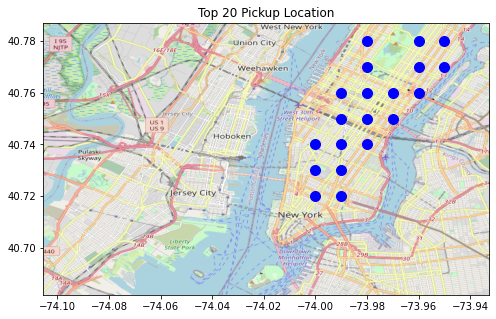

In [14]:
### by pickupdropoff_cat

def map_location(latlong_str):
    ''' get rounded latitude and longitude and return area name'''
    if latlong_str in latlong_dict.keys():
        address = latlong_dict[latlong_str]
        if address == 'unknown':
            return 'unknown'
        elif all(i in address.keys() for i in ['suburb','road']):
            return ', '.join([address['road'],address['suburb']])
        elif all(i in address.keys() for i in ['county','road']):
            return ', '.join([address['road'],address['county']])
        elif all(i in address.keys() for i in ['city_district','road']):
            return ', '.join([address['road'],address['city_district']])
        elif all(i in address.keys() for i in ['suburb','neighbourhood']):
            return ', '.join([address['neighbourhood'],address['suburb']])
        elif all(i in address.keys() for i in ['county','neighbourhood']):
            return ', '.join([address['neighbourhood'],address['county']])
        elif 'suburb' in address.keys():
            return address['suburb']
        elif 'county' in address.keys():
            return address['county']
        elif 'city_district' in address.keys():
            return address['city_district']
        else:
            return 'unknown'
    else:
        return 'unknown'

udf_map_location = udf(map_location,StringType())

total_rows = df_trip.count()
df_top_pickup = df_trip.withColumn('pickup_lat',F.round(col('pickup_latitude'),2))\
    .withColumn('pickup_long',F.round(col('pickup_longitude'),2))\
    .withColumn('pickup_location',
udf_map_location(F.concat(F.round(col('pickup_latitude'),2), lit(', '), F.round(col('pickup_longitude'),2))))\
    .groupBy('pickup_lat','pickup_long','pickup_location').count().sort(F.desc('count'))\
        .withColumn('percentage',F.round(col('count')/total_rows,2)).limit(20).toPandas().rename(columns={'count':'trips'})

df_top_pickup['cumu_pct'] = df_top_pickup['percentage'].cumsum()
print(df_top_pickup[['pickup_location','trips','percentage','cumu_pct']])

BBox = ((-74.10559376003222, -73.93255909206347, 
         40.68170548671376, 40.78706628021547))

nyc_map = plt.imread('nyc_map.png')
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(df_top_pickup.pickup_long, df_top_pickup.pickup_lat, zorder=1, alpha= 1, c='b', s=100)
ax.set_title('Top 20 Pickup Locations')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(nyc_map, zorder=0, extent = BBox, aspect= 'equal')


                      dropoff_location   trips  percentage  cumu_pct
0          Lexington Avenue, Manhattan  834917        0.06      0.06
1                6th Avenue, Manhattan  819317        0.06      0.12
2          West 33rd Street, Manhattan  757930        0.05      0.17
3          East 38th Street, Manhattan  737768        0.05      0.22
4          East 21st Street, Manhattan  598672        0.04      0.26
5          West 45th Street, Manhattan  533449        0.04      0.30
6                3rd Avenue, Manhattan  498171        0.03      0.33
7           East 9th Street, Manhattan  436443        0.03      0.36
8   Central Park Outer Loop, Manhattan  408001        0.03      0.39
9          Lafayette Street, Manhattan  402545        0.03      0.42
10         East 26th Street, Manhattan  399605        0.03      0.45
11         West 16th Street, Manhattan  383965        0.03      0.48
12         East 84th Street, Manhattan  373105        0.03      0.51
13               2nd Avenue, Manha

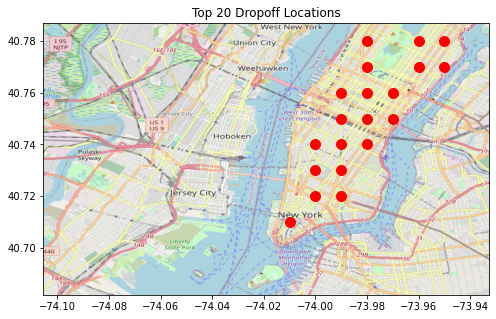

In [15]:
df_top_dropoff = df_trip.withColumn('dropoff_lat',F.round(col('dropoff_latitude'),2))\
    .withColumn('dropoff_long',F.round(col('dropoff_longitude'),2))\
    .withColumn('dropoff_location',
udf_map_location(F.concat(F.round(col('dropoff_latitude'),2), lit(', '), F.round(col('dropoff_longitude'),2))))\
    .groupBy('dropoff_lat','dropoff_long','dropoff_location').count().sort(F.desc('count'))\
        .withColumn('percentage',F.round(col('count')/total_rows,2)).limit(20).toPandas().rename(columns={'count':'trips'})

df_top_dropoff['cumu_pct'] = df_top_dropoff['percentage'].cumsum()
print(df_top_dropoff[['dropoff_location','trips','percentage','cumu_pct']])

fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(df_top_dropoff.dropoff_long, df_top_dropoff.dropoff_lat, zorder=1, alpha= 1, c='r', s=100)
ax.set_title('Top 20 Dropoff Locations')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(nyc_map, zorder=0, extent = BBox, aspect= 'equal')

In [10]:
print(datetime.datetime(1970,1,1,0,0,0).strftime('%A'))
print(datetime.datetime(1970,1,1,0,0,0).weekday())

baseday_dict = {}
for i in range(4,11):
    baseday = datetime.datetime(1970,1,1,0,0,0)+relativedelta(days=i)
    baseday_str = baseday.strftime('%Y-%m-%d')
    baseday_dict[baseday.strftime('%a')] = baseday_str

intfunc = udf(lambda x: int(x),IntegerType())
dayofweekadj = udf(lambda x: 7 if x==1 else x-1,IntegerType())
cumuhour = udf(lambda x: ((x[0]-1)*24)+x[1],IntegerType())
timeofweek = udf(lambda x: baseday_dict[x[0]]+str(' ')+x[1].zfill(2)+str(':00:00'),StringType())

df_trip = df_trip.withColumn('pickup_dow',F.date_format(F.to_timestamp(col('pickup_datetime')),'E'))\
    .withColumn('pickup_dow_num',dayofweekadj(F.dayofweek(F.to_timestamp(col('pickup_datetime')))))\
        .withColumn('pickup_hour',intfunc(F.date_format(F.to_timestamp(col('pickup_datetime')),'H')))\
            .withColumn('pickup_how',cumuhour(F.array(col('pickup_dow_num'),col('pickup_hour'))))\
                .withColumn('pickup_tow',F.to_timestamp(timeofweek(F.array(col('pickup_dow'),col('pickup_hour')))))

df_trip_hour_of_week = df_trip.groupBy('pickup_how','pickup_dow_num','pickup_dow','pickup_hour').count()\
                    .sort(col('pickup_how').asc()).toPandas()


Thursday
3


## Trips by time of the week

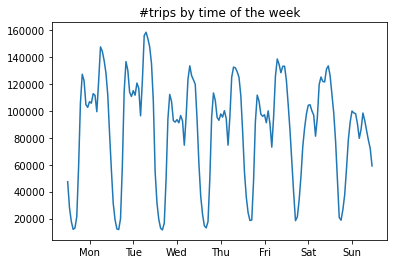

In [17]:
fig, ax = plt.subplots()

xticks = [i for i in df_trip_hour_of_week['pickup_how']][12::24]
xlabels = [i for i in df_trip_hour_of_week['pickup_dow'].unique()]

ax.set_title('#trips by time of the week')
ax.plot(df_trip_hour_of_week['pickup_how'],df_trip_hour_of_week['count'])
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels,ha='center')
plt.show()

## Cluster Analysis by fare_per_mile and sec_per_mile

### Impute extreme fare_per_mile and sec_per_mile caused by small distance

In [6]:
quantiles_spm = df_trip\
    .select(F.percentile_approx('sec_per_mile', [0.5,0.9,0.95,1.0], 1000000).alias('quantiles')).collect()[0].quantiles

print(quantiles_spm)

quantiles_fpm = df_trip\
    .select(F.percentile_approx('fare_per_mile', [0.5,0.9,0.95,1.0], 1000000).alias('quantiles')).collect()[0].quantiles

print(quantiles_fpm)

fpm_impute = udf(lambda x: quantiles_fpm[-2] if x >= quantiles_fpm[-2] else x,DoubleType())
spm_impute = udf(lambda x: quantiles_spm[-2] if x >= quantiles_spm[-2] else x,DoubleType())

df_trip = df_trip.withColumn('fare_per_mile',fpm_impute(col('fare_per_mile')))\
    .withColumn('sec_per_mile',spm_impute(col('sec_per_mile')))

[404.7, 782.6, 981.9, 12750000.0]
[6.61, 11.27, 13.73, 260000.0]


In [85]:
assemble=VectorAssembler(inputCols=['fare_per_mile','sec_per_mile'], outputCol='features')
assembled_data=assemble.transform(df_trip.select('trip_id','fare_per_mile','sec_per_mile'))
# assembled_data.show(5)

scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data.select('features'))
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show(5)

+-------+-------------+------------+-------------+--------------------+
|trip_id|fare_per_mile|sec_per_mile|     features|        standardized|
+-------+-------------+------------+-------------+--------------------+
|      1|         4.84|       242.0| [4.84,242.0]|[1.82078549817351...|
|      2|        13.73|       981.9|[13.73,981.9]|[5.16516216733933...|
|      3|         4.27|       212.0| [4.27,212.0]|[1.60635414818200...|
|      4|         7.13|       452.8| [7.13,452.8]|[2.68227285164817...|
|      5|         6.59|       263.6| [6.59,263.6]|[2.47912736218253...|
+-------+-------------+------------+-------------+--------------------+
only showing top 5 rows



In [89]:
silhouette_scores=[]
sum_squared_distances = []
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,6):
    
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    
    score=evaluator.evaluate(output)
    silhouette_scores.append(score)

    sum_squared_distance = KMeans_fit.summary.trainingCost
    sum_squared_distances.append(sum_squared_distance)
    
    print("Silhouette Score:",score)
    print("sum squared distance:",sum_squared_distance)

Silhouette Score: 0.7512574597033195
sum squared distance: 10663199.39278
Silhouette Score: 0.6648893262923843
sum squared distance: 5979443.244130298
Silhouette Score: 0.6035157637224701
sum squared distance: 4284399.706919675
Silhouette Score: 0.6060935478026755
sum squared distance: 3594725.16290914


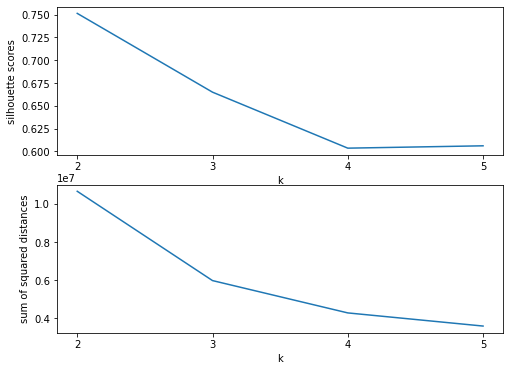

In [90]:
fig, [ax,ax2] = plt.subplots(2,1, figsize =(8,6))
ax.plot(range(2,6),[round(i,5) for i in silhouette_scores])
ax.set_xlabel('k')
ax.set_xticks(range(2,6))
ax.set_ylabel('silhouette scores')

ax2.plot(range(2,6),[round(i) for i in sum_squared_distances])
ax2.set_xlabel('k')
ax2.set_xticks(range(2,6))
ax2.set_ylabel('sum of squared distances')

# fig.tight_layout()
plt.show()

In [94]:
### Scoring

k = 2
KMeans_algo=KMeans(featuresCol='standardized', k=k)
KMeans_fit=KMeans_algo.fit(data_scale_output)
# output=KMeans_fit.transform(data_scale_output)

# kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
# model = kmeans.fit(data_scale_output)

transformed = KMeans_fit.transform(data_scale_output)
transformed.groupBy('prediction').count().show()

+----------+--------+
|prediction|   count|
+----------+--------+
|         1| 4073204|
|         0|10433539|
+----------+--------+



In [126]:
to_array = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))
udfx = udf(lambda x: x[0],DoubleType())
udfy = udf(lambda x: x[1],DoubleType())

df_cluster = transformed.withColumn('coords',to_array(col('standardized')))\
    .withColumn('x',F.round(udfx(col('coords')),2))\
        .withColumn('y',F.round(udfy(col('coords')),2))\
            .groupBy('prediction','x','y').count().toPandas()

Cluster Centers: 


<AxesSubplot:title={'center':'cluster centroids'}, xlabel='scaled_fare_per_mile', ylabel='scaled_sec_per_mile'>

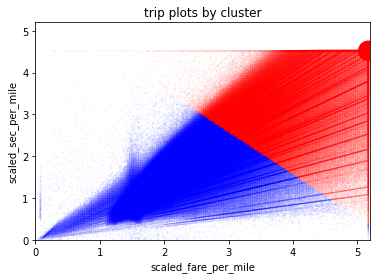

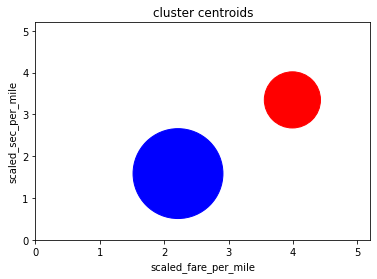

In [161]:
color_dict = {0:'b',1:'r'}
df_cluster['color'] = df_cluster['prediction'].apply(lambda x: color_dict[x])
total_rows = int(df_cluster.shape[0])
df_cluster['percentage'] = df_cluster['count'].apply(lambda x: float(x)/total_rows)
df_cluster.plot.scatter(x='x',
                        y='y',
                        title = 'trip plots by cluster',
                        xlim=(0.0, 5.2),
                        ylim=(0.0, 5.2),
                        xlabel = 'scaled_fare_per_mile',
                        ylabel = 'scaled_sec_per_mile',
                        s=df_cluster['percentage']*100,
                        c='color')

centers = KMeans_fit.clusterCenters()

print("Cluster Centers: ")
cluster_size = [float(i)/total_rows for i in df_cluster.groupby(by='prediction')['count'].sum().tolist()]

df_centroids =pd.DataFrame([[centers[0][0],centers[0][1],cluster_size[0],'b'],
                            [centers[1][0],centers[1][1],cluster_size[1],'r']],
                            columns=['x','y','size','color'])
df_centroids.plot.scatter(x='x',
            y='y',
            title='cluster centroids',
            xlim=(0.0, 5.2),
            ylim=(0.0, 5.2),
            xlabel = 'scaled_fare_per_mile',
            ylabel = 'scaled_sec_per_mile',
            s=df_centroids['size']*100,
            c='color')

In [164]:
df_trip = df_trip\
    .join(transformed.withColumnRenamed('prediction','cluster').select('trip_id','cluster'),'trip_id','inner')

In [167]:
print('all trips')
df_trip.select('fare_per_mile','sec_per_mile').describe().show()
print('trip cluster 0')
df_trip.filter(col('cluster')==0).select('fare_per_mile','sec_per_mile').describe().show()
print('trip cluster 1')
df_trip.filter(col('cluster')==1).select('fare_per_mile','sec_per_mile').describe().show()

all trips
+-------+------------------+------------------+
|summary|     fare_per_mile|      sec_per_mile|
+-------+------------------+------------------+
|  count|          14506743|          14506743|
|   mean| 7.210223860034954|451.65590191399843|
| stddev|2.6581934032620436|217.09393756864011|
|    min|              0.09|               0.2|
|    max|             13.73|             981.9|
+-------+------------------+------------------+

trip cluster 0
+-------+-----------------+-----------------+
|summary|    fare_per_mile|     sec_per_mile|
+-------+-----------------+-----------------+
|  count|         10433539|         10433539|
|   mean|5.884000817939146|344.2196638264351|
| stddev|1.390608877134337|113.5209233850262|
|    min|             0.09|              0.2|
|    max|            13.73|            981.9|
+-------+-----------------+-----------------+

trip cluster 1
+-------+------------------+------------------+
|summary|     fare_per_mile|      sec_per_mile|
+-------+-------

## Explain Difference between cluster 0 and 1

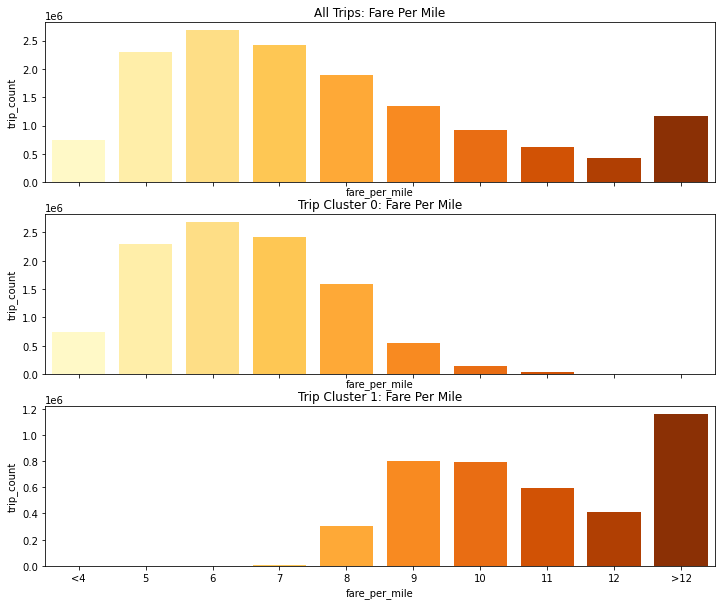

In [174]:
quantiles = df_trip\
    .select(F.percentile_approx('fare_per_mile', percentile_list, 1000000).alias('quantiles')).collect()[0].quantiles

threshold = [0]+[i for i in range(4,13,1)] + [quantiles[-1]]

bucketizer = Bucketizer(splits=threshold,inputCol="fare_per_mile", outputCol="buckets")
df_buck = bucketizer.setHandleInvalid("skip").transform(df_trip)
# df_buck.select('fare_per_mile','buckets').show(5)

bucketlabels = [str('<')+str(threshold[1])]+[str(i) for i in threshold[2:-1]] + [str('>')+str(threshold[-2])]
bucketlabels_dict = dict(enumerate(bucketlabels))

df_fare_per_mile_grouped = df_buck.groupBy('buckets').count().toPandas().sort_values(by=['buckets'])
df_fare_per_mile_grouped['fare_per_mile'] = df_fare_per_mile_grouped['buckets'].apply(lambda x: bucketlabels_dict[x])
df_fare_per_mile_grouped = df_fare_per_mile_grouped.rename(columns={'count':'trip_count'})

df_buck = bucketizer.setHandleInvalid("skip").transform(df_trip.filter(col('cluster')==0))
# df_buck.select('fare_per_mile','buckets').show(5)

bucketlabels = [str('<')+str(threshold[1])]+[str(i) for i in threshold[2:-1]] + [str('>')+str(threshold[-2])]
bucketlabels_dict = dict(enumerate(bucketlabels))

df_fare_per_mile_c0 = df_buck.groupBy('buckets').count().toPandas().sort_values(by=['buckets'])
df_fare_per_mile_c0['fare_per_mile'] = df_fare_per_mile_c0['buckets'].apply(lambda x: bucketlabels_dict[x])
df_fare_per_mile_c0 = df_fare_per_mile_c0.rename(columns={'count':'trip_count'})

df_buck = bucketizer.setHandleInvalid("skip").transform(df_trip.filter(col('cluster')==1))
# df_buck.select('fare_per_mile','buckets').show(5)

bucketlabels = [str('<')+str(threshold[1])]+[str(i) for i in threshold[2:-1]] + [str('>')+str(threshold[-2])]
bucketlabels_dict = dict(enumerate(bucketlabels))

df_fare_per_mile_c1 = df_buck.groupBy('buckets').count().toPandas().sort_values(by=['buckets'])
df_fare_per_mile_c1['fare_per_mile'] = df_fare_per_mile_c1['buckets'].apply(lambda x: bucketlabels_dict[x])
df_fare_per_mile_c1 = df_fare_per_mile_c1.rename(columns={'count':'trip_count'})

fig, axarr = plt.subplots(3,1, figsize =(12,10), sharex=True)

sns.barplot(x = 'fare_per_mile', y = 'trip_count', 
            data = df_fare_per_mile_grouped,
            palette = 'YlOrBr',
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'gray', errwidth = 2,  
            ci = 'sd',
            ax = axarr[0]
            ).set_title('All Trips: Fare Per Mile')

sns.barplot(x = 'fare_per_mile', y = 'trip_count', 
            data = df_fare_per_mile_c0,
            palette = 'YlOrBr',
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'gray', errwidth = 2,  
            ci = 'sd',
            ax = axarr[1]
            ).set_title('Trip Cluster 0: Fare Per Mile')

sns.barplot(x = 'fare_per_mile', y = 'trip_count', 
            data = df_fare_per_mile_c1,
            palette = 'YlOrBr',
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'gray', errwidth = 2,  
            ci = 'sd',
            ax = axarr[2]  
            ).set_title('Trip Cluster 1: Fare Per Mile')

plt.show()



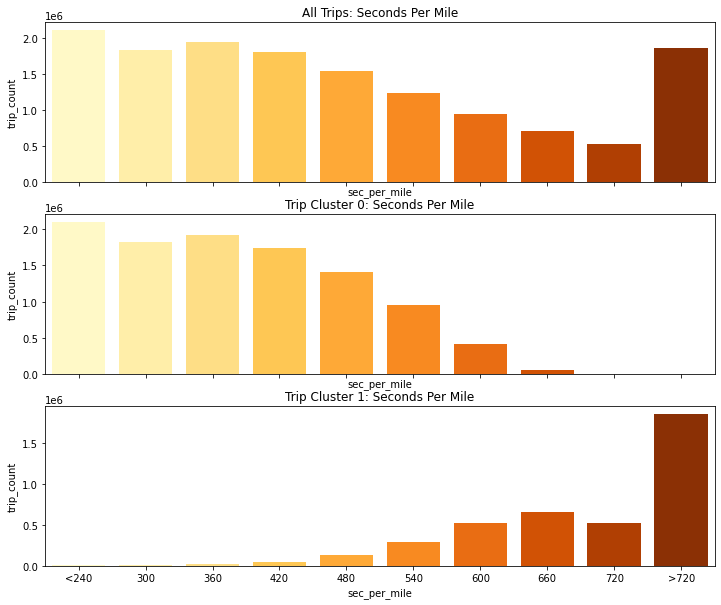

In [176]:
### sec_per_mile

percentile_list = [i/100.0 for i in range(0,110,10)]

quantiles = df_trip\
    .select(F.percentile_approx('sec_per_mile', percentile_list, 1000000).alias('quantiles')).collect()[0].quantiles

threshold = [0]+[i*60 for i in range(4,13,1)] + [quantiles[-1]]

bucketizer = Bucketizer(splits=threshold,inputCol="sec_per_mile", outputCol="buckets")
df_buck = bucketizer.setHandleInvalid("skip").transform(df_trip)
# df_buck.select('sec_per_mile','buckets').show(5)

bucketlabels = [str('<')+str(int(threshold[1]))]+[str(int(i)) for i in threshold[2:-1]] + [str('>')+str(int(threshold[-2]))]
bucketlabels_dict = dict(enumerate(bucketlabels))

df_sec_per_mile_grouped = df_buck.groupBy('buckets').count().toPandas().sort_values(by=['buckets'])
df_sec_per_mile_grouped['sec_per_mile'] = df_sec_per_mile_grouped['buckets'].apply(lambda x: bucketlabels_dict[x])
df_sec_per_mile_grouped = df_sec_per_mile_grouped.rename(columns={'count':'trip_count'})

df_buck = bucketizer.setHandleInvalid("skip").transform(df_trip.filter(col('cluster')==0))
# df_buck.select('fare_per_mile','buckets').show(5)

bucketlabels = [str('<')+str(threshold[1])]+[str(i) for i in threshold[2:-1]] + [str('>')+str(threshold[-2])]
bucketlabels_dict = dict(enumerate(bucketlabels))

df_sec_per_mile_c0 = df_buck.groupBy('buckets').count().toPandas().sort_values(by=['buckets'])
df_sec_per_mile_c0['sec_per_mile'] = df_sec_per_mile_c0['buckets'].apply(lambda x: bucketlabels_dict[x])
df_sec_per_mile_c0 = df_sec_per_mile_c0.rename(columns={'count':'trip_count'})

df_buck = bucketizer.setHandleInvalid("skip").transform(df_trip.filter(col('cluster')==1))
# df_buck.select('fare_per_mile','buckets').show(5)

bucketlabels = [str('<')+str(threshold[1])]+[str(i) for i in threshold[2:-1]] + [str('>')+str(threshold[-2])]
bucketlabels_dict = dict(enumerate(bucketlabels))

df_sec_per_mile_c1 = df_buck.groupBy('buckets').count().toPandas().sort_values(by=['buckets'])
df_sec_per_mile_c1['sec_per_mile'] = df_sec_per_mile_c1['buckets'].apply(lambda x: bucketlabels_dict[x])
df_sec_per_mile_c1 = df_sec_per_mile_c1.rename(columns={'count':'trip_count'})

fig, axarr = plt.subplots(3,1, figsize =(12,10), sharex=True)

sns.barplot(x = 'sec_per_mile', y = 'trip_count', 
            data = df_sec_per_mile_grouped,
            palette = 'YlOrBr',
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'gray', errwidth = 2,  
            ci = 'sd',
            ax = axarr[0]
            ).set_title('All Trips: Seconds Per Mile')

sns.barplot(x = 'sec_per_mile', y = 'trip_count', 
            data = df_sec_per_mile_c0,
            palette = 'YlOrBr',
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'gray', errwidth = 2,  
            ci = 'sd',
            ax = axarr[1]
            ).set_title('Trip Cluster 0: Seconds Per Mile')

sns.barplot(x = 'sec_per_mile', y = 'trip_count', 
            data = df_sec_per_mile_c1,
            palette = 'YlOrBr',
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'gray', errwidth = 2,  
            ci = 'sd',
            ax = axarr[2]  
            ).set_title('Trip Cluster 1: Seconds Per Mile')

plt.show()

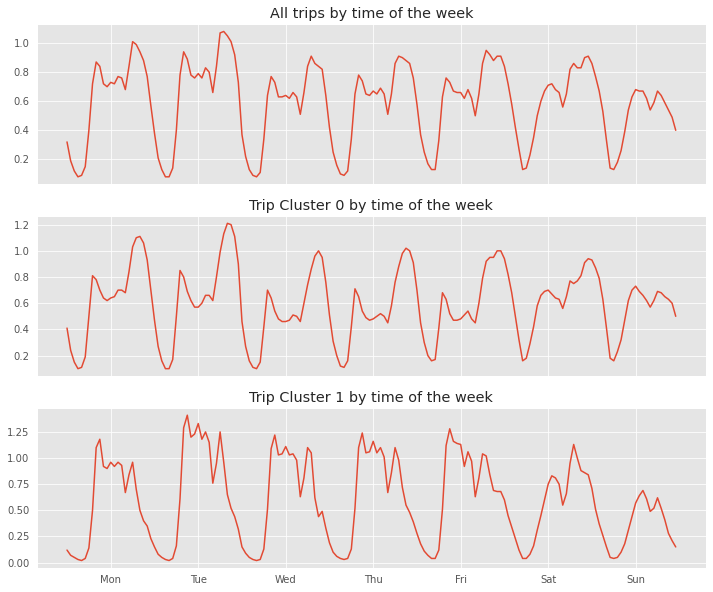

In [332]:
df_trip_hour_of_week['percentage'] = df_trip_hour_of_week['count'].apply(lambda x: round(100*x/float(df_trip_hour_of_week['count'].sum()),2))

df_trip_hour_of_week_c0 = df_trip.filter(col('cluster')==0)\
    .groupBy('pickup_how','pickup_dow_num','pickup_dow','pickup_hour').count()\
        .sort(col('pickup_how').asc()).toPandas()
df_trip_hour_of_week_c0['percentage'] = df_trip_hour_of_week_c0['count'].apply(lambda x: round(100*x/float(df_trip_hour_of_week_c0['count'].sum()),2))


df_trip_hour_of_week_c1 = df_trip.filter(col('cluster')==1)\
    .groupBy('pickup_how','pickup_dow_num','pickup_dow','pickup_hour').count()\
        .sort(col('pickup_how').asc()).toPandas()
df_trip_hour_of_week_c1['percentage'] = df_trip_hour_of_week_c1['count'].apply(lambda x: round(100*x/float(df_trip_hour_of_week_c1['count'].sum()),2))


fig, [ax,ax0,ax1] = plt.subplots(3,1, figsize =(12,10), sharex=True)

xticks = [i for i in df_trip_hour_of_week['pickup_how']][12::24]
xlabels = [i for i in df_trip_hour_of_week['pickup_dow'].unique()]

ax.set_title('All trips by time of the week')
ax.plot(df_trip_hour_of_week['pickup_how'],df_trip_hour_of_week['percentage'])
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels,ha='center')

ax0.set_title('Trip Cluster 0 by time of the week')
ax0.plot(df_trip_hour_of_week_c0['pickup_how'],df_trip_hour_of_week_c0['percentage'])
ax0.set_xticks(xticks)
ax0.set_xticklabels(xlabels,ha='center')

ax1.set_title('Trip Cluster 1 by time of the week')
ax1.plot(df_trip_hour_of_week_c1['pickup_how'],df_trip_hour_of_week_c1['percentage'])
ax1.set_xticks(xticks)
ax1.set_xticklabels(xlabels,ha='center')

plt.show()

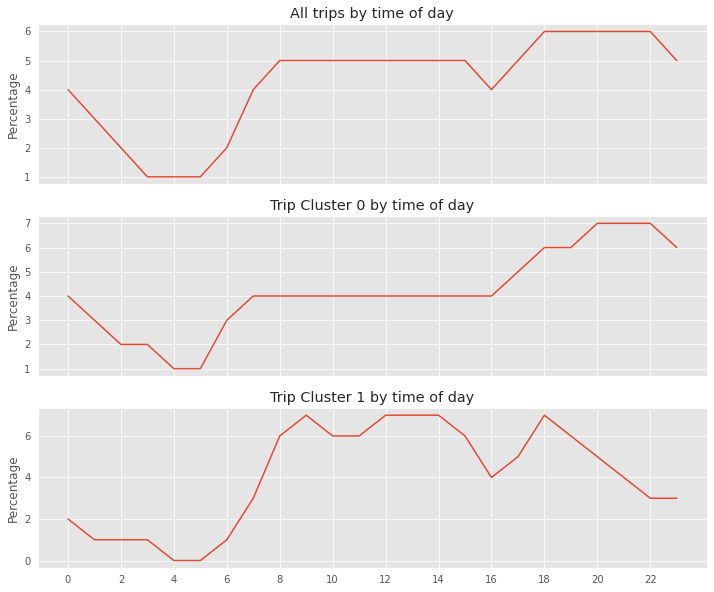

In [334]:
df_trip_hour_of_day = df_trip.groupBy('pickup_hour').count().sort('pickup_hour').toPandas()
df_trip_hour_of_day['percentage'] = df_trip_hour_of_day['count'].apply(lambda x: round(100*x/float(df_trip_hour_of_day['count'].sum())))

df_trip_hour_of_day_c0 = df_trip.filter(col('cluster')==0)\
    .groupBy('pickup_hour').count()\
        .sort('pickup_hour').toPandas()
df_trip_hour_of_day_c0['percentage'] = df_trip_hour_of_day_c0['count'].apply(lambda x: round(100*x/float(df_trip_hour_of_day_c0['count'].sum())))

df_trip_hour_of_day_c1 = df_trip.filter(col('cluster')==1)\
    .groupBy('pickup_hour').count()\
        .sort('pickup_hour').toPandas()
df_trip_hour_of_day_c1['percentage'] = df_trip_hour_of_day_c1['count'].apply(lambda x: round(100*x/float(df_trip_hour_of_day_c1['count'].sum())))

fig, [ax,ax0,ax1] = plt.subplots(3,1, figsize =(12,10), sharex=True)

xticks = [i for i in df_trip_hour_of_day['pickup_hour']][0:24:2]

ax.set_title('All trips by time of day')
ax.plot(df_trip_hour_of_day['pickup_hour'],df_trip_hour_of_day['percentage'])
ax.set_xticks(xticks)
ax.set_ylabel('Percentage')

ax0.set_title('Trip Cluster 0 by time of day')
ax0.plot(df_trip_hour_of_day_c0['pickup_hour'],df_trip_hour_of_day_c0['percentage'])
ax0.set_xticks(xticks)
ax0.set_ylabel('Percentage')

ax1.set_title('Trip Cluster 1 by time of day')
ax1.plot(df_trip_hour_of_day_c1['pickup_hour'],df_trip_hour_of_day_c1['percentage'])
ax1.set_xticks(xticks)
ax1.set_ylabel('Percentage')

plt.show()

### Weekday trips by time of day

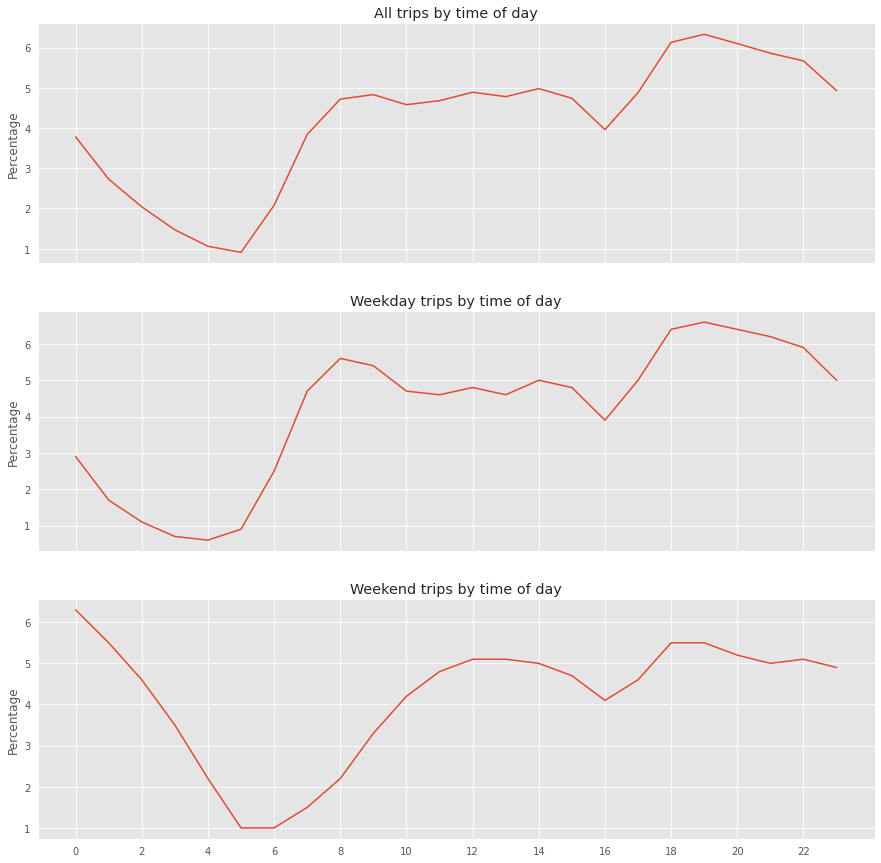

In [343]:
df_trip_hour_of_week['flg_weekday'] = np.where(df_trip_hour_of_week['pickup_dow_num'].isin(range(1,6)),1,0)
df_trip_hour = df_trip_hour_of_week.groupby(['pickup_hour'],as_index=False)['count'].sum()
total_trips = df_trip_hour['count'].sum()
df_trip_hour['percentage'] = df_trip_hour['count'].apply(lambda x: round(100*x/float(total_trips),2))

df_trip_hour_wkday_wkend = df_trip_hour_of_week.groupby(['flg_weekday','pickup_hour'],as_index=False)['count'].sum()
wkday_wkend_dict = df_trip_hour_wkday_wkend.groupby(by='flg_weekday')['count'].sum().to_dict()
df_trip_hour_wkday_wkend['percentage'] = df_trip_hour_wkday_wkend.apply(lambda row: round(100*row['count']/float(wkday_wkend_dict[row['flg_weekday']]),1),axis=1)

fig, [ax,ax1,ax0] = plt.subplots(3,1, figsize =(15,15), sharex=True)

xticks = [i for i in df_trip_hour['pickup_hour']][0:24:2]
ax.set_title('All trips by time of day')
ax.plot(df_trip_hour['pickup_hour'],df_trip_hour['percentage'])
ax.set_ylabel('Percentage')

ax1.set_title('Weekday trips by time of day')
ax1.plot(df_trip_hour_wkday_wkend.iloc[np.where(df_trip_hour_wkday_wkend['flg_weekday']==1)]['pickup_hour'],
df_trip_hour_wkday_wkend.iloc[np.where(df_trip_hour_wkday_wkend['flg_weekday']==1)]['percentage'])
ax1.set_ylabel('Percentage')

ax0.set_xticks(xticks)
ax0.set_title('Weekend trips by time of day')
ax0.plot(df_trip_hour_wkday_wkend.iloc[np.where(df_trip_hour_wkday_wkend['flg_weekday']==0)]['pickup_hour'],
df_trip_hour_wkday_wkend.iloc[np.where(df_trip_hour_wkday_wkend['flg_weekday']==0)]['percentage'])
ax0.set_ylabel('Percentage')
plt.show()


#--------------------------------------------------------
# Divide time of the day into 3 groups
# 1) 0-<8
# 2) 8-<16
# 3) 16-24
#--------------------------------------------------------

In [190]:
total_rows = df_trip.count()
df_trip_cat = df_trip.groupBy('pickup_area','dropoff_area').count().sort(F.desc(col('count')))\
    .withColumn('percentage',F.round(col('count')/total_rows,2)).toPandas()

df_trip_cat['cumu_gain'] = df_trip_cat['percentage'].cumsum()

#--------------------------------------------------------
# Divide trip into 3 categories
# 1) intra_mht (Intra Manhattan)
# 2) inter_mht
# 3) non_mht
#--------------------------------------------------------

,trip_category,percentage
0,Manhattan - Brooklyn,0.03
1,Manhattan - Manhattan,0.86
2,Manhattan - Queens,0.03
3,Queens - Manhattan,0.03
4,others,0.04


In [12]:
def trip_category(pickup,dropoff):
    if ('Manhattan' in pickup) and ('Manhattan' in dropoff):
        return 'intra_mht'
    elif ('Manhattan' in pickup) or ('Manhattan' in dropoff):
        return 'inter_mht'
    else:
        return 'non_mht'

udftripcat = udf(trip_category,StringType())

def pickup_period(pickup_hour):
    if pickup_hour < 8:
        return 'a.0-<8'
    elif pickup_hour < 16:
        return 'b.8-<16'
    else:
        return 'c.16-24'

udftimeofday = udf(pickup_period,StringType())

df_trip = df_trip.withColumn('trip_category',udftripcat(col('pickup_area'),col('dropoff_area')))\
    .withColumn('pickup_period',udftimeofday(col('pickup_hour')))

df_cluster_profiles = df_trip.groupBy('cluster','pickup_period','trip_category').count().toPandas()
df_trip_profiles = df_trip.groupBy('pickup_period','trip_category').count().toPandas()

### Trips by pickup-dropoff category

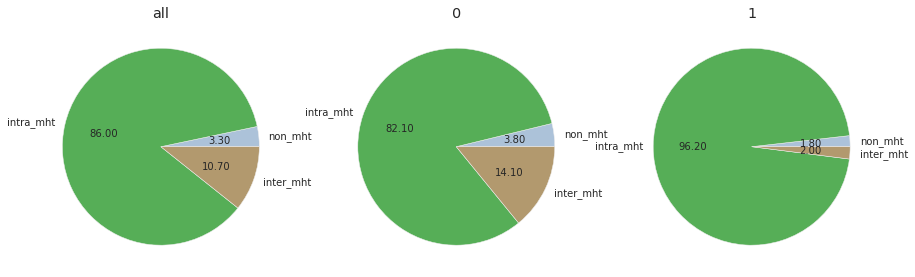

In [398]:
df_trip_profiles_cat = df_trip_profiles.groupby(by='trip_category',as_index=False)['count'].sum()
total_trips = df_trip_profiles_cat['count'].sum()
df_trip_profiles_cat['percentage'] = df_trip_profiles_cat['count'].apply(lambda x: round(100*x/float(total_trips),1))
df_trip_profiles_cat = df_trip_profiles_cat.sort_values(by='trip_category',ascending=0)

cluster_size = df_cluster_profiles.groupby(by='cluster')['count'].sum().to_dict()
df_cluster_profiles_cat = df_cluster_profiles.groupby(by=['cluster','trip_category'],as_index=False)['count'].sum()
df_cluster_profiles_cat['percentage'] = df_cluster_profiles_cat.apply(lambda row: round(100*row['count']/float(cluster_size[row['cluster']]),1),axis=1)
df_cluster_profiles_cat = df_cluster_profiles_cat.sort_values(by=['cluster','trip_category'],ascending=[0,0])

df_trip_profiles_cat['cluster'] = 'all'
df_cluster_profiles_cat['cluster'] = df_cluster_profiles_cat['cluster'].apply(str)

df_profiles_cat = pd.concat([df_trip_profiles_cat,df_cluster_profiles_cat],ignore_index=True)

fig, axes = plt.subplots(1,3, figsize=(15,5))
for ax, cluster in zip(axes, ['all','0','1']):
    df = df_profiles_cat.iloc[np.where(df_profiles_cat['cluster']==cluster)]
    ax.pie(df['percentage'], labels=df['trip_category'], autopct='%.2f', colors=colors)
    ax.set(ylabel='', title=cluster, aspect='equal')
plt.show()

In [304]:
cluster_size = {0:df_cluster_profiles.iloc[np.where(df_cluster_profiles['cluster']==0)]['count'].sum(),
                1:df_cluster_profiles.iloc[np.where(df_cluster_profiles['cluster']==1)]['count'].sum()}

df_cluster_profiles['percentage'] = df_cluster_profiles.apply(lambda row: round(100*float(row['count'])/cluster_size[row['cluster']],1),axis=1)
df_cluster_profiles['trip_label'] = df_cluster_profiles.apply(lambda row: ', '.join([row['pickup_period'],row['trip_category']]),axis=1)

total_rows = int(df_trip_profiles['count'].sum())
df_trip_profiles['percentage'] = df_trip_profiles['count'].apply(lambda x: round(100*float(x)/total_rows,1))
df_trip_profiles['trip_label'] = df_trip_profiles.apply(lambda row: ', '.join([row['pickup_period'],row['trip_category']]),axis=1)

df_trip_profiles['cluster'] = 'all'
df_cluster_profiles['cluster'] = df_cluster_profiles['cluster'].apply(str)
cols_to_keep = ['cluster','trip_label','percentage']
df_stack_profiles = pd.concat([df_cluster_profiles[cols_to_keep],df_trip_profiles[cols_to_keep]],ignore_index=True)


df_profiles_tp = pd.pivot_table(df_stack_profiles,index=['cluster'],columns=['trip_label'],values=['percentage']).reset_index()
df_profiles_tp.columns = [v[0] if i==0 else v[1] for i,v in enumerate(df_profiles_tp.columns.values)]
df_profiles_tp

### Trips by difference between Acutal and Geo Distance

In [474]:
df_trip.select('trip_distance','geo_distance').show(10)

+-------------+------------+
|trip_distance|geo_distance|
+-------------+------------+
|          0.9|      0.9481|
|          9.6|      6.8263|
|         3.26|      2.0731|
|          1.7|      1.2988|
|         0.97|       0.707|
|          2.1|       1.457|
|         6.15|      3.9727|
|          0.8|      0.5841|
|         2.53|      2.1829|
|         1.82|      1.7676|
+-------------+------------+
only showing top 10 rows



In [13]:
### Add abs_distance_diff to df_trip
df_trip = df_trip.withColumn('abs_distance_diff',F.abs(col('trip_distance')-col('geo_distance')))

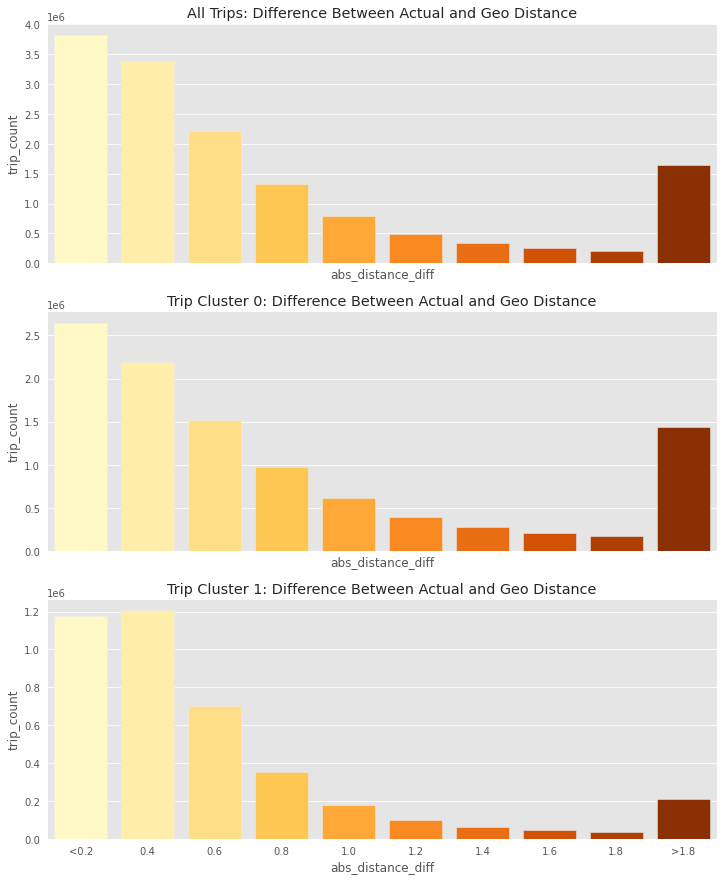

In [481]:
### See Difference between Actual and Geo Distance by cluster

quantiles = df_trip\
    .select(F.percentile_approx('abs_distance_diff', percentile_list, 1000000).alias('quantiles')).collect()[0].quantiles

threshold = [0]+[i/float(10) for i in range(2,20,2)] + [quantiles[-1]]

bucketizer = Bucketizer(splits=threshold,inputCol="abs_distance_diff", outputCol="buckets")
df_buck = bucketizer.setHandleInvalid("skip").transform(df_trip)
# df_buck.select('fare_per_mile','buckets').show(5)

bucketlabels = [str('<')+str(threshold[1])]+[str(i) for i in threshold[2:-1]] + [str('>')+str(threshold[-2])]
bucketlabels_dict = dict(enumerate(bucketlabels))

df_distance_diff_grouped = df_buck.groupBy('buckets').count().toPandas().sort_values(by=['buckets'])
df_distance_diff_grouped['abs_distance_diff'] = df_distance_diff_grouped['buckets'].apply(lambda x: bucketlabels_dict[x])
df_distance_diff_grouped = df_distance_diff_grouped.rename(columns={'count':'trip_count'})

df_buck = bucketizer.setHandleInvalid("skip").transform(df_trip.filter(col('cluster')==0))
# df_buck.select('fare_per_mile','buckets').show(5)

bucketlabels = [str('<')+str(threshold[1])]+[str(i) for i in threshold[2:-1]] + [str('>')+str(threshold[-2])]
bucketlabels_dict = dict(enumerate(bucketlabels))

df_distance_diff_c0 = df_buck.groupBy('buckets').count().toPandas().sort_values(by=['buckets'])
df_distance_diff_c0['abs_distance_diff'] = df_distance_diff_c0['buckets'].apply(lambda x: bucketlabels_dict[x])
df_distance_diff_c0 = df_distance_diff_c0.rename(columns={'count':'trip_count'})

df_buck = bucketizer.setHandleInvalid("skip").transform(df_trip.filter(col('cluster')==1))
# df_buck.select('fare_per_mile','buckets').show(5)

bucketlabels = [str('<')+str(threshold[1])]+[str(i) for i in threshold[2:-1]] + [str('>')+str(threshold[-2])]
bucketlabels_dict = dict(enumerate(bucketlabels))

df_distance_diff_c1 = df_buck.groupBy('buckets').count().toPandas().sort_values(by=['buckets'])
df_distance_diff_c1['abs_distance_diff'] = df_distance_diff_c1['buckets'].apply(lambda x: bucketlabels_dict[x])
df_distance_diff_c1 = df_distance_diff_c1.rename(columns={'count':'trip_count'})

fig, axarr = plt.subplots(3,1, figsize =(12,15), sharex=True)

sns.barplot(x = 'abs_distance_diff', y = 'trip_count', 
            data = df_distance_diff_grouped,
            palette = 'YlOrBr',
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'gray', errwidth = 2,  
            ci = 'sd',
            ax = axarr[0]
            ).set_title('All Trips: Difference Between Actual and Geo Distance')

sns.barplot(x = 'abs_distance_diff', y = 'trip_count', 
            data = df_distance_diff_c0,
            palette = 'YlOrBr',
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'gray', errwidth = 2,  
            ci = 'sd',
            ax = axarr[1]
            ).set_title('Trip Cluster 0: Difference Between Actual and Geo Distance')

sns.barplot(x = 'abs_distance_diff', y = 'trip_count', 
            data = df_distance_diff_c1,
            palette = 'YlOrBr',
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'gray', errwidth = 2,  
            ci = 'sd',
            ax = axarr[2]  
            ).set_title('Trip Cluster 1: Difference Between Actual and Geo Distance')

plt.show()

## Measure fare estimates and time estimates error from applying means

In [452]:
cols_to_keep = ['trip_id','cluster','geo_distance','trip_distance',
'fare_amount','trip_time_in_secs','fare_per_mile','sec_per_mile']

fare_per_mile_means_all = df_trip.select(F.mean('fare_per_mile')).collect()[0][0]
sec_per_mile_means_all = df_trip.select(F.mean('sec_per_mile')).collect()[0][0]

cluster_dict = df_trip.groupBy('cluster').agg(F.mean('fare_per_mile').alias('fare_per_mile'),
F.mean('sec_per_mile').alias('sec_per_mile'))\
    .toPandas().set_index('cluster').to_dict()

getfareavgall = udf(lambda x: round(fare_per_mile_means_all*x,2), DoubleType())
gettimeavgall = udf(lambda x: round(sec_per_mile_means_all*x,2), DoubleType())

getfareavgcluster = udf(lambda x: round(cluster_dict['fare_per_mile'][x[0]]*x[1],2),DoubleType())
gettimeavgcluster = udf(lambda x: round(cluster_dict['sec_per_mile'][x[0]]*x[1],2),DoubleType())

getsum = udf(lambda x: round(sum([x[0],x[1]]),2),DoubleType())

df_trip_means_error= df_trip.select(*[cols_to_keep])\
    .withColumn('fare_all_est',getfareavgall(col('geo_distance')))\
        .withColumn('fare_cluster_est',getfareavgcluster(F.array([col('cluster'),col('geo_distance')])))\
            .withColumn('fare_all_error',getsum(F.array([col('fare_amount'),-1*col('fare_all_est')])))\
                .withColumn('fare_cluster_error',getsum(F.array([col('fare_amount'),-1*col('fare_cluster_est')])))\
                    .withColumn('time_all_est',gettimeavgall(col('geo_distance')))\
                        .withColumn('time_cluster_est',gettimeavgcluster(F.array([col('cluster'),col('geo_distance')])))\
                            .withColumn('time_all_error',getsum(F.array([col('trip_time_in_secs'),-1*col('time_all_est')])))\
                                .withColumn('time_cluster_error',getsum(F.array([col('trip_time_in_secs'),-1*col('time_cluster_est')])))

In [468]:
### Calculate Root Means Squared Error for both types of estimates

rootmean = udf(lambda x: (x[0]/x[1])**(0.5),DoubleType())

df_trip_means_error.withColumn('squared_error_all_fare',col('fare_all_error')**2)\
    .withColumn('squared_error_all_time',col('time_all_error')**2)\
        .withColumn('squared_error_cluster_fare',col('fare_cluster_error')**2)\
            .withColumn('squared_error_cluster_time',col('time_cluster_error')**2)\
                .agg(F.sum('squared_error_all_fare').alias('squared_error_all_fare'),
       F.sum('squared_error_all_time').alias('squared_error_all_time'),
       F.sum('squared_error_cluster_fare').alias('squared_error_cluster_fare'),
       F.sum('squared_error_cluster_time').alias('squared_error_cluster_time'),
       F.count('trip_id').alias('count'))\
           .withColumn('rmse_all_fare',rootmean(F.array([col('squared_error_all_fare'),col('count')])))\
               .withColumn('rmse_all_time',rootmean(F.array([col('squared_error_all_time'),col('count')])))\
                   .withColumn('rmse_cluster_fare',rootmean(F.array([col('squared_error_cluster_fare'),col('count')])))\
                       .withColumn('rmse_cluster_time',rootmean(F.array([col('squared_error_cluster_time'),col('count')])))\
                           .select('rmse_all_fare','rmse_all_time','rmse_cluster_fare','rmse_cluster_time').show()

+-----------------+-----------------+------------------+------------------+
|    rmse_all_fare|    rmse_all_time| rmse_cluster_fare| rmse_cluster_time|
+-----------------+-----------------+------------------+------------------+
|8.474671545698387|687.2763475376505|5.1857283755100125|430.61338736751424|
+-----------------+-----------------+------------------+------------------+



In [498]:
df_trip_means_error.withColumn('squared_error_all_fare',col('fare_all_error')**2)\
    .withColumn('squared_error_all_time',col('time_all_error')**2)\
        .withColumn('squared_error_cluster_fare',col('fare_cluster_error')**2)\
            .withColumn('squared_error_cluster_time',col('time_cluster_error')**2)\
                .groupBy('cluster').agg(F.sum('squared_error_all_fare').alias('squared_error_all_fare'),
       F.sum('squared_error_all_time').alias('squared_error_all_time'),
       F.sum('squared_error_cluster_fare').alias('squared_error_cluster_fare'),
       F.sum('squared_error_cluster_time').alias('squared_error_cluster_time'),
       F.count('trip_id').alias('count'))\
           .withColumn('rmse_all_fare',rootmean(F.array([col('squared_error_all_fare'),col('count')])))\
               .withColumn('rmse_all_time',rootmean(F.array([col('squared_error_all_time'),col('count')])))\
                   .withColumn('rmse_cluster_fare',rootmean(F.array([col('squared_error_cluster_fare'),col('count')])))\
                       .withColumn('rmse_cluster_time',rootmean(F.array([col('squared_error_cluster_time'),col('count')])))\
                           .select('cluster','rmse_all_fare','rmse_all_time','rmse_cluster_fare','rmse_cluster_time').show()

+-------+-----------------+------------------+------------------+------------------+
|cluster|    rmse_all_fare|     rmse_all_time| rmse_cluster_fare| rmse_cluster_time|
+-------+-----------------+------------------+------------------+------------------+
|      1|4.057649209598303|399.98947123046463|3.5674795134377217|  259.380479659361|
|      0|9.665950424348473| 770.9030700364528| 5.694003526006946|481.19949416043215|
+-------+-----------------+------------------+------------------+------------------+



## Create df for daily income maximisation model and save as Parquet

In [571]:
cols_to_keep = ['trip_id','taxi_driver_id','taxi_id','driver_id',
                'pickup_date','pickup_datetime','trip_time_in_secs',
                'pickup_area','pickup_period','fare_amount','surcharge','tip_amount']

df_for_maximization = df_trip.select(*[cols_to_keep])

df_for_maximization.write.format('parquet').saveAsTable('trip_driver_fmax')

## Create df for predicting fare and tip amount given pickup-dropoff coords and time of the week

In [22]:
cols_to_keep = ['trip_id','driver_id','pickup_latitude','pickup_longitude','pickup_area',
                'dropoff_latitude','dropoff_longitude','geo_distance','pickup_hour',
                'pickup_period','pickup_tow','fare_amount','tolls_amount','tip_amount',
                'payment_type','trip_time_in_secs']

df_trip_fare_tip_predict = df_trip.select(*[cols_to_keep])

df_trip_fare_tip_predict.write.format('parquet').saveAsTable('trip_fare_tip_predict2')

In [1]:
# import shutil
# shutil.rmtree('spark-warehouse/trip_clean_all')
# shutil.move('taxi_driver_dim.parquet', 'spark-warehouse/taxi_driver_dim.parquet')